In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#Implementamos la estructura de la NN
class NeuralNet(nn.Module):
    def __init__(self, hidden_size, output_size=1,input_size=1):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.Tanh()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.Tanh()
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.Tanh()
        self.l4 = nn.Linear(hidden_size, hidden_size)
        self.relu4 = nn.Tanh()
        self.l5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu1(out)
        out = self.l2(out)
        out = self.relu2(out)
        out = self.l3(out)
        out = self.relu3(out)
        out = self.l4(out)
        out = self.relu4(out)
        out = self.l5(out)
        return out

In [3]:
#Creamos el criterio de la funcion L_Data
criterion = nn.MSELoss()

# Define la funcion de costo y condiciones iniciales
def initial_condition_loss(y, target_value):
    return nn.MSELoss()(y, target_value)

In [4]:
# Vector de tiempo como entrada de la NN
t_numpy = np.arange(0, 1+0.01, 0.001, dtype=np.float32)
t = torch.from_numpy(t_numpy).reshape(len(t_numpy), 1)
t.requires_grad_(True)


g = 9.8
k = 10
m = 5 
# Iniciamos las neuronas
model = NeuralNet(hidden_size=64)

# Costo y omptimizador
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# epocas
num_epochs = int(1.4e3)

# Guardamos valores de la funcion de costo y las epocas
loss_values = []
epoch_values = []


In [5]:
len(t_numpy)

1010

### Ajustar el paso de epsilon al mismo paso del dominio

In [6]:
for epoch in range(num_epochs):

    
    epsilon = torch.normal(0,0.001, size=(len(t),1)).float()
    t_train = t + epsilon

    # Forward pass
    y_pred = model(t_train)

    # Caalcular la derivada del forward pass
    dy_dt = torch.autograd.grad(y_pred, 
                                t_train, 
                                grad_outputs=torch.ones_like(y_pred), 
                                create_graph=True)[0]
    d2y_dt2 = torch.autograd.grad(dy_dt, 
                                t_train, 
                                grad_outputs=torch.ones_like(dy_dt), 
                                create_graph=True)[0]
    

    # Funcion física
    loss_DE = criterion(d2y_dt2 + g, torch.zeros_like(d2y_dt2)) #+ (k/m)*dy_dt

    # Condicion inicial 
    loss_IC = initial_condition_loss(model(torch.tensor([[0.0]])), 
                                     torch.tensor([[10.0]]))

    loss = loss_DE + loss_IC

    # Backward pass 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Actualizamos L y epocas
    loss_values.append(loss.item())
    epoch_values.append(epoch)

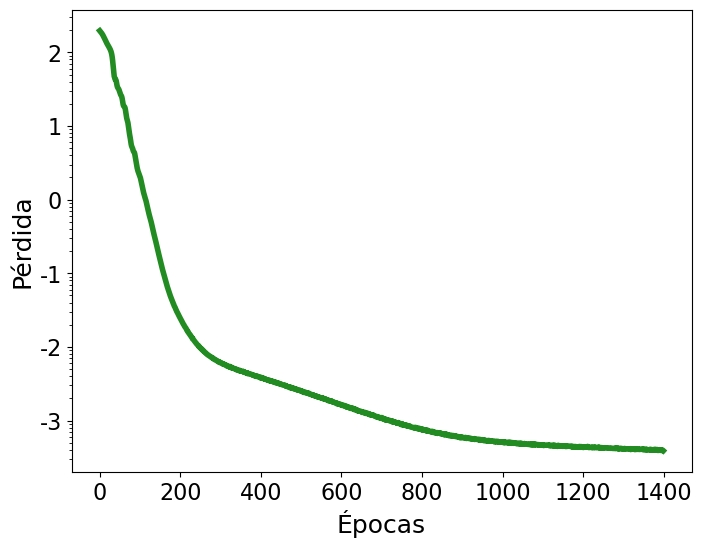

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter

# Función para formatear las etiquetas del eje y
def log_format(exponent, pos):
    return f"{int(np.log10(exponent))}"  # Extraer el exponente como entero


# Crear la gráfica
plt.figure(figsize=(8, 6))
plt.plot(epoch_values, loss_values, lw=4, color = 'forestgreen', alpha= 1)

plt.xlabel('Épocas', fontsize=18)  # Actualización del texto del eje x
plt.ylabel('Pérdida', fontsize=18)
plt.yscale('log')  # Escala logarítmica en y

# Ajustar las marcas y etiquetas del eje y
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))  # Marcas en potencias de 10
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format))  # Formato del eje y

# Ajustar las marcas y etiquetas del eje x
#plt.gca().xaxis.set_major_formatter(FuncFormatter(x_format))  # Formato personalizado para miles

#plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.savefig('CaidaLibreBestLoss.png')
plt.show()


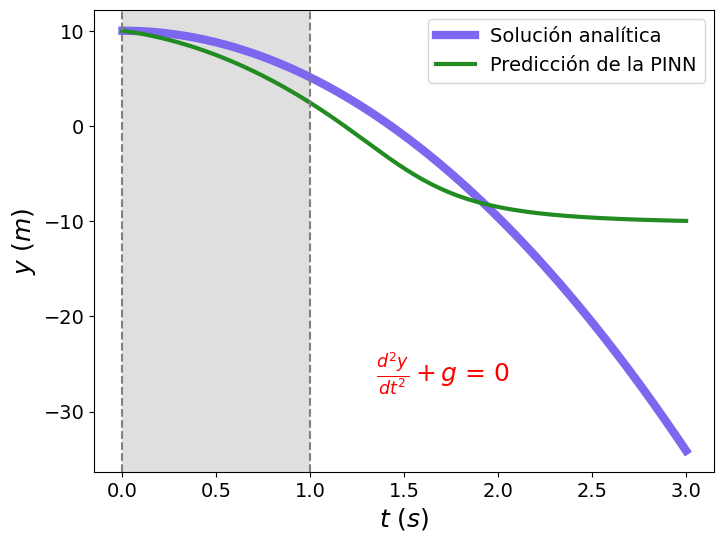

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
g=9.8

# Función para la solución analítica
def caida_libre(t):
    y0 = 10
    y = y0 - 0.5*g*t**2  # Solución analítica 
    return y

# Genera puntos de tiempo para evaluar la solución
t_test = torch.linspace(0, 3, 2500).reshape(-1, 1)

# Evalúa la red neuronal en los puntos de tiempo de prueba
with torch.no_grad():
    y_pred_test = model(t_test)

# Calcula la solución analítica en los mismos puntos de tiempo
y_analytical = caida_libre(t_test.numpy())

# Gráfica de la solución predicha por la red neuronal y la solución analítica
plt.figure(figsize=(8, 6))
plt.plot(t_test.numpy(), y_analytical,color='mediumslateblue', lw=6, label='Solución analítica')
plt.plot(t_test.numpy(), y_pred_test.numpy(), color = 'forestgreen',lw=3, label='Predicción de la PINN')
plt.xlabel('$t~(s)$', fontsize=18)
plt.ylabel('$y~(m)$', fontsize=18)
#plt.title('Solución de caída libre')
plt.axvline(x=0, color='gray', linestyle='--')  # Línea vertical en t = -5
plt.axvline(x=1, color='gray', linestyle='--' )   # Línea vertical en t = 5
plt.text(1.35, -27, r'$\frac{d^2y}{dt^2}+g$ = 0', fontsize=18, color='r')
plt.axvspan(0, 1, facecolor='gray', alpha=0.25)
#plt.text(0.15, -27, r'(b)', fontsize=30, color='r')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('CaidaSimplesWorst.png')
plt.show()
